<a href="https://colab.research.google.com/github/rs-saran/sindy/blob/main/Chaotic_Lorenz_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chaotic Lorenz System

In [1]:
pip install pysindy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 9.9 MB/s 


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

import numpy as np

from scipy.integrate import solve_ivp
from scipy.io import loadmat

from pysindy.utils import lorenz
import pysindy as ps

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

The Lorenz system serves as an example of a nonlinear ODE whose solutions exhibit chaotic dynamics evolving on a strange attractor. The Lorenz system is given by

$$ \begin{aligned} \dot x &= \sigma(y-x)\\ \dot y &= x(\rho - z) - y \\ \dot z &= xy - \beta z, \end{aligned} $$
with $\sigma=10$, $\rho=28$, and $\beta=\tfrac{8}{3}$ for this example. We generate our training data starting from the initial condition $(-8, 8, 27)$. Note that for this example we also collect measurements of derivatives of state variables, $(\dot x, \dot y, \dot z)

In [4]:
# Generate training data

dt = 0.001
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27] 
x_train = solve_ivp(lorenz, t_train_span, 
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)

In [21]:
print("total number of samples:",len(x_train))

total number of samples: 100000


In [19]:
#finding the best hyperparameters

model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)

search.fit(x_train)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.001}
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [6]:
# Fit the model with best hyperparameters

poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [7]:
# Simulate and plot the results
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
plot_kws1 = dict(linewidth=1)

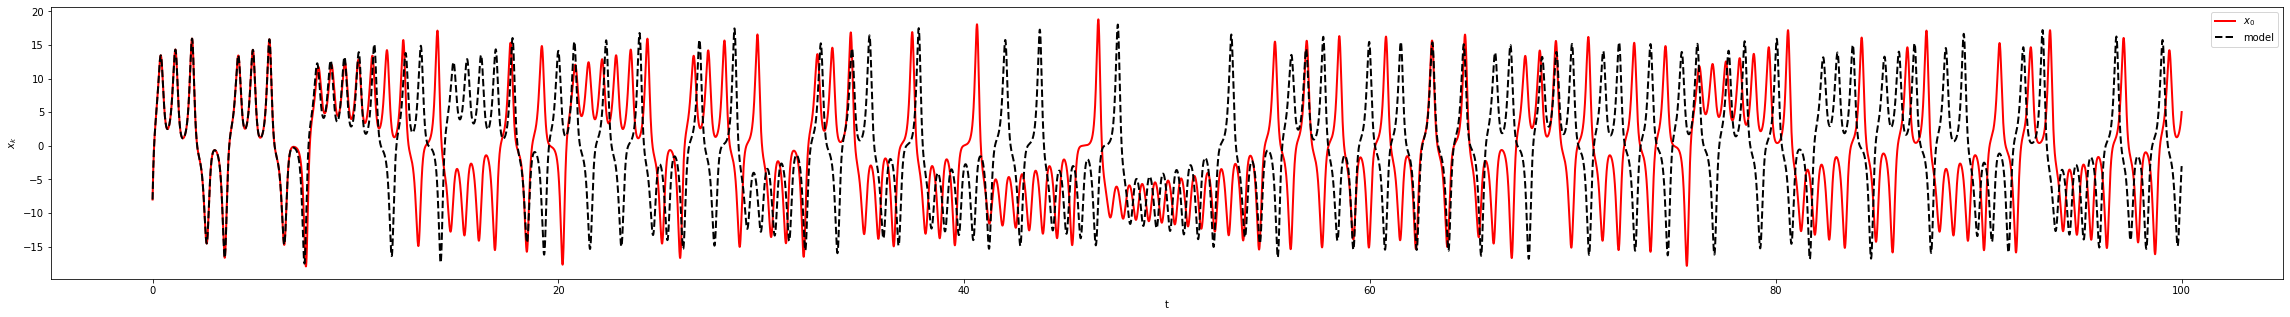

In [9]:
fig = plt.figure(figsize=(40,5))
plt.plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
plt.plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

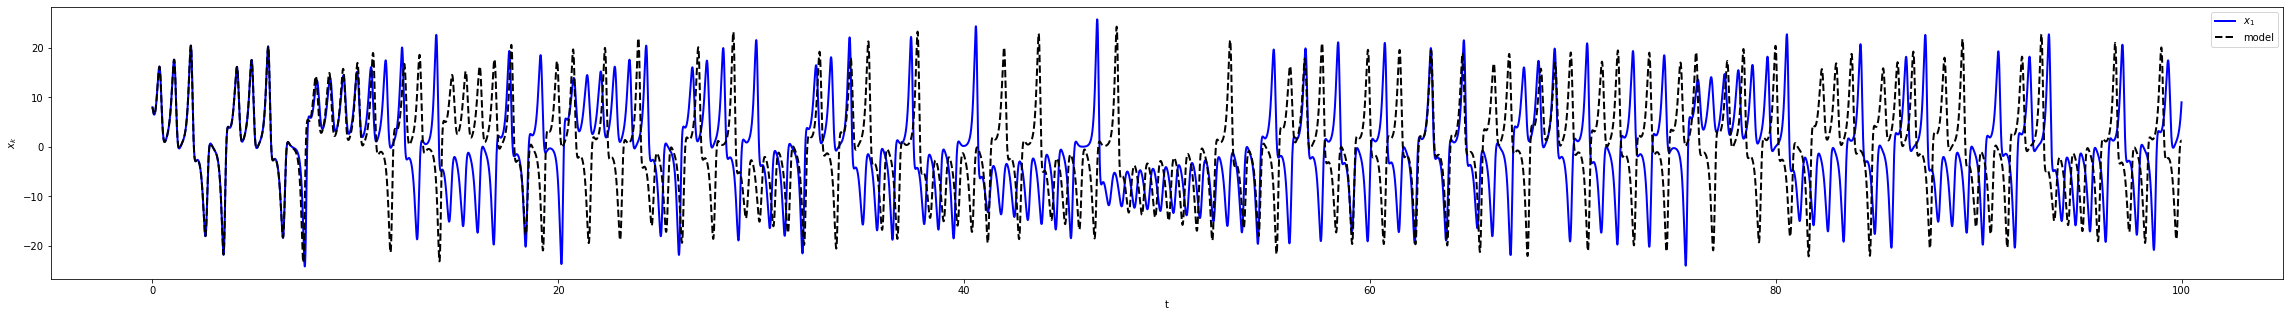

In [10]:
fig = plt.figure(figsize=(40,5))
plt.plot(t_train, x_train[:, 1], "b", label="$x_1$", **plot_kws)
plt.plot(t_train, x_sim[:, 1], "k--", label="model", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

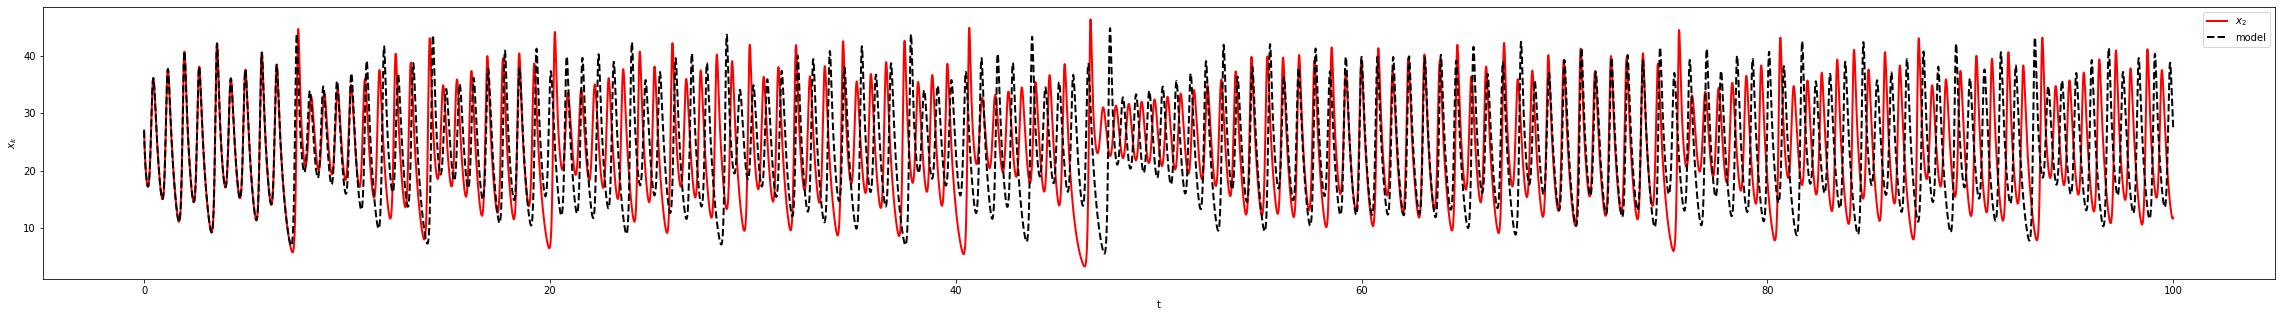

In [11]:
fig = plt.figure(figsize=(40,5))
plt.plot(t_train, x_train[:, 2], "r", label="$x_2$", **plot_kws)
plt.plot(t_train, x_sim[:, 2], "k--", label="model", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

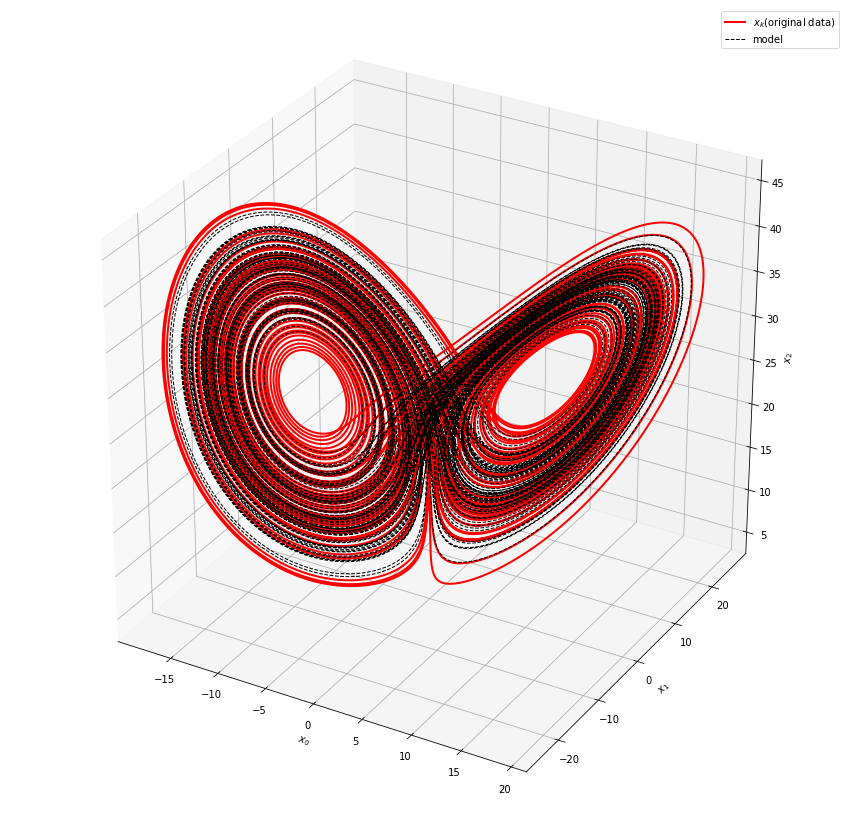

In [14]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$(original data)", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws1)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

"In the Lorenz example, the ability to capture dynamics on the
attractor is more important than the ability to predict an individual
trajectory, because chaos will quickly cause any small variations in
initial conditions or model coefficients to diverge exponentially." 

### Observations for varying levels of noise

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


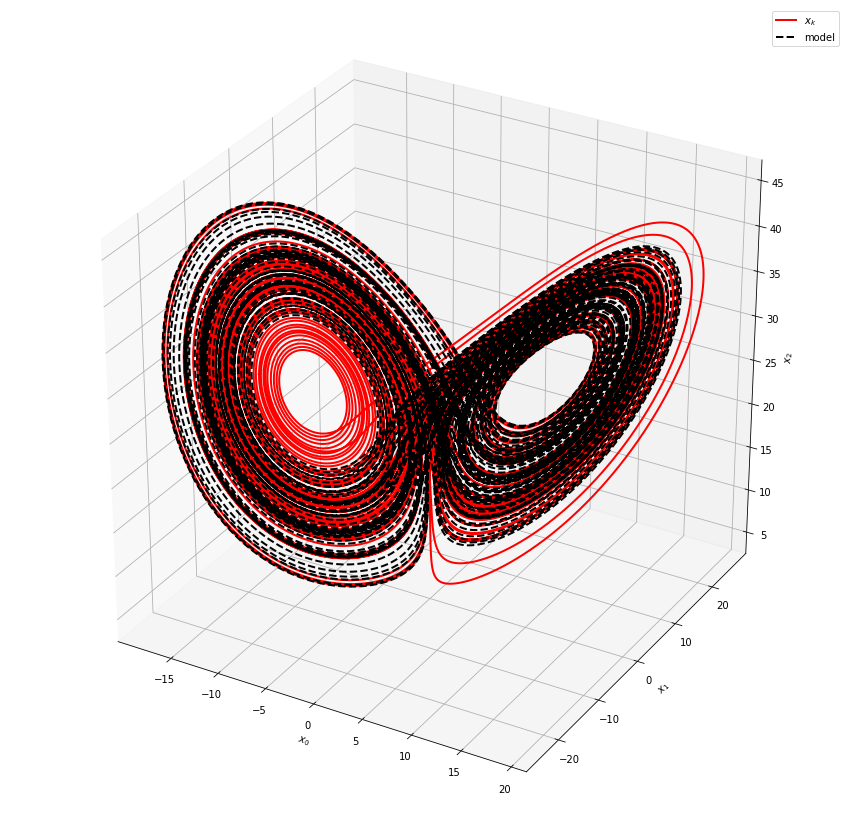

In [20]:
#adding noise on a scale of 1e-4
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-4, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


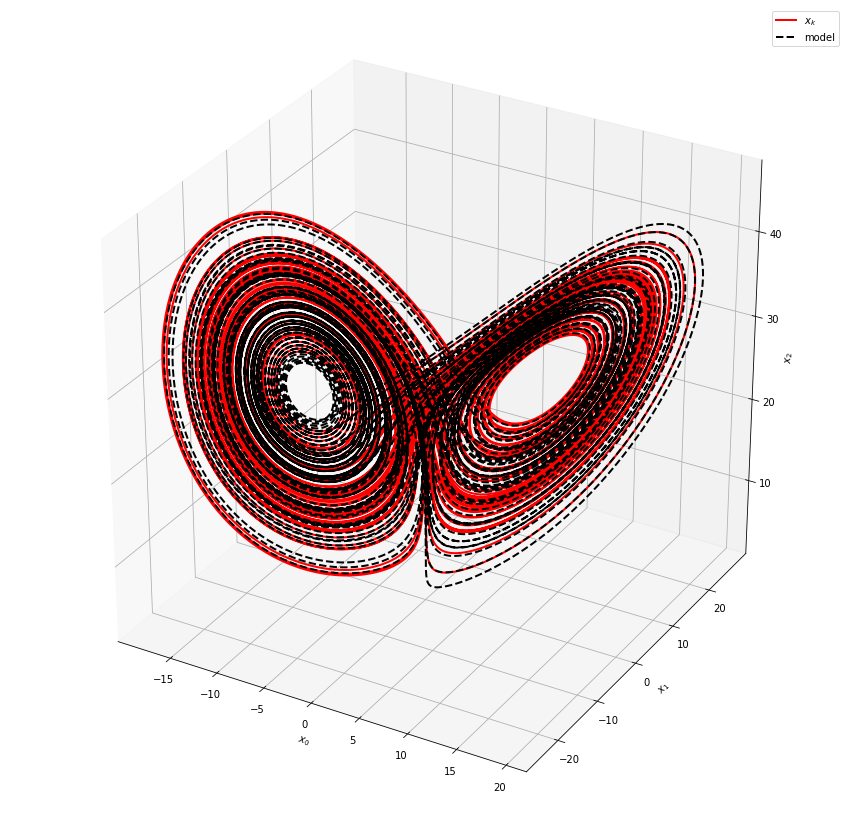

In [22]:
# adding noise on a scale of 1e-3
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-3, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -0.002 1 + -2.666 x2 + 1.000 x0 x1


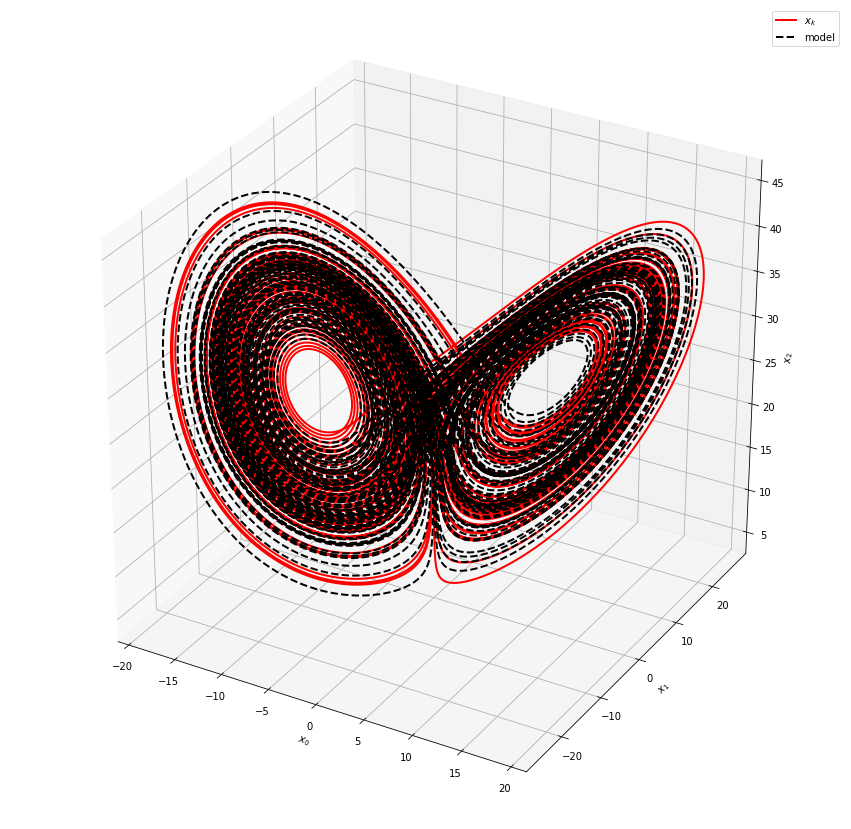

In [30]:
# adding noise on a scale of 1e-2
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-2, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = -0.701 1 + -9.865 x0 + 9.920 x1 + 0.096 x2 + 0.016 x0^2 + -0.016 x0 x1 + -0.004 x0 x2 + 0.004 x1^2 + 0.002 x1 x2 + -0.003 x2^2
(x1)' = 1.170 1 + 27.934 x0 + -0.961 x1 + -0.159 x2 + -0.026 x0^2 + 0.024 x0 x1 + -0.998 x0 x2 + -0.005 x1^2 + -0.001 x1 x2 + 0.005 x2^2
(x2)' = 0.758 1 + 0.004 x0 + -0.003 x1 + -2.768 x2 + -0.015 x0^2 + 1.011 x0 x1 + -0.001 x1^2 + 0.003 x2^2


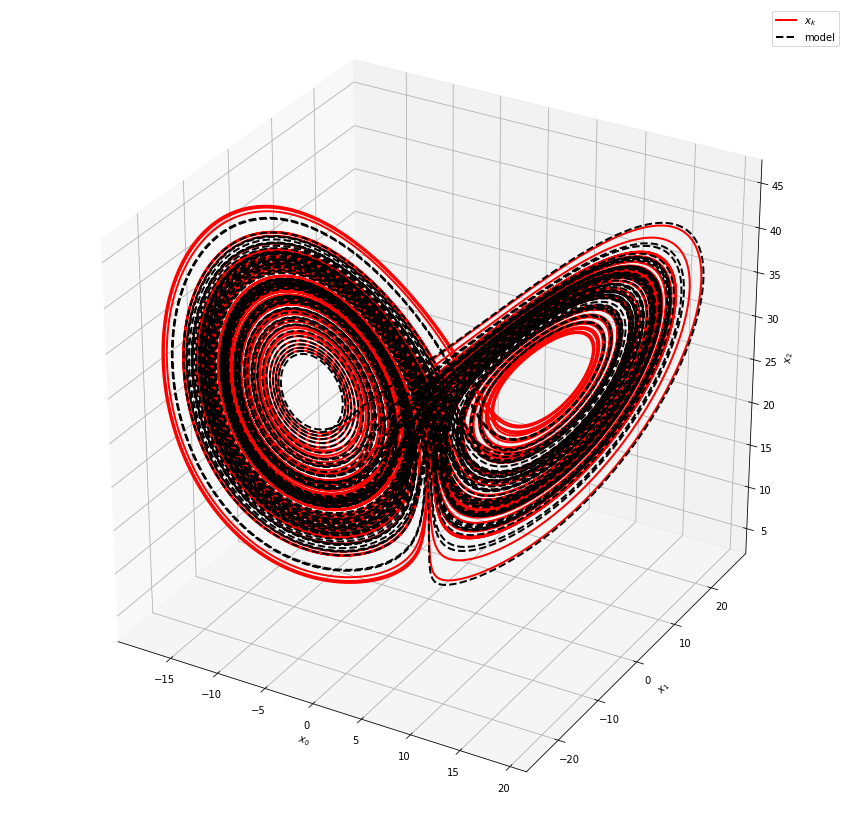

In [31]:
# adding noise on a scale of 1e-1
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-1, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

(x0)' = 0.053 1 + 0.397 x0 + 3.751 x1 + -0.214 x2 + -0.060 x0^2 + -0.013 x0 x1 + -0.271 x0 x2 + 0.039 x1^2 + 0.152 x1 x2 + 0.011 x2^2
(x1)' = 0.149 1 + 20.171 x0 + 3.371 x1 + -0.220 x2 + -0.031 x0^2 + -0.032 x0 x1 + -0.787 x0 x2 + 0.036 x1^2 + -0.112 x1 x2 + 0.009 x2^2
(x2)' = -0.395 1 + -0.821 x0 + 0.373 x1 + -2.889 x2 + 0.036 x0^2 + 0.771 x0 x1 + 0.022 x0 x2 + 0.130 x1^2 + -0.010 x1 x2 + 0.011 x2^2


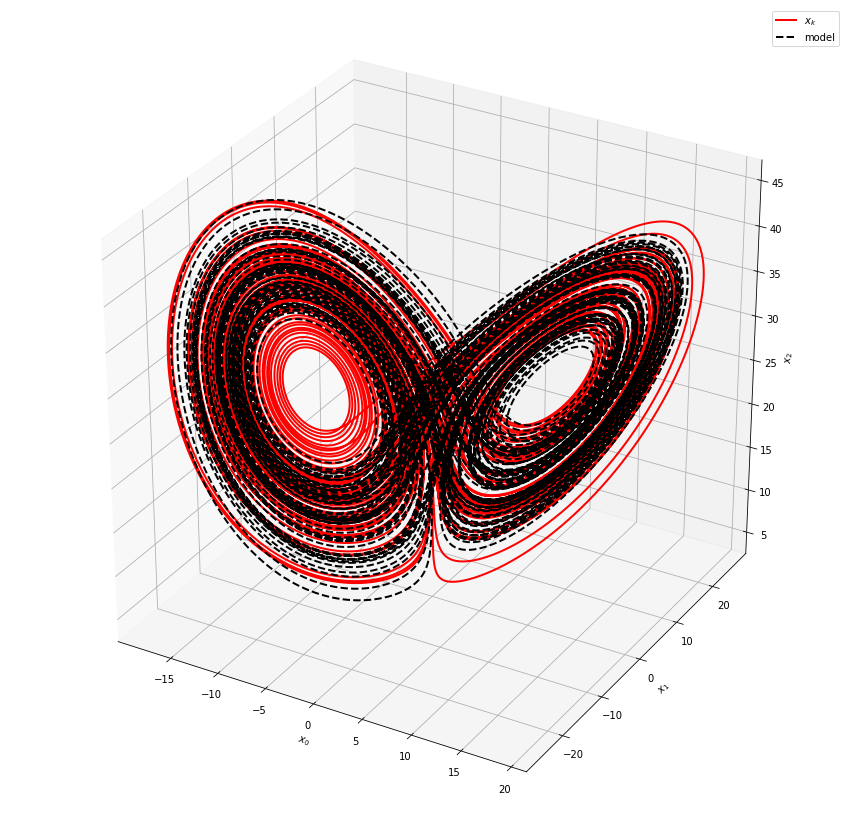

In [32]:
# adding noise on a scale of 1
poly_order = 2
threshold = 0.001

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train + np.random.normal(scale=1e-0, size=x_train.shape), t=dt, quiet=True)
model.print()
x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

Number of samples of data required to get original equaions for particular levels of noise

no noise

In [36]:
# considering only 0.1% of the samples without any noise i.e, 100 samples of 100,000
#finding the best hyperparameters
model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train[:100])

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': <pysindy.feature_library.fourier_library.FourierLibrary object at 0x7fa410113670>, 'optimizer__threshold': 0.001}
(x0)' = 12.667 sin(1 x0) + -4.148 cos(1 x0) + 145.135 sin(1 x1) + 6.233 cos(1 x1) + 25.956 sin(1 x2) + -12.432 cos(1 x2)
(x1)' = -1.477 sin(1 x0) + -8.979 cos(1 x0) + -26.183 sin(1 x1) + 1.166 cos(1 x1) + 8.376 sin(1 x2) + 9.635 cos(1 x2)
(x2)' = -11.676 sin(1 x0) + 4.297 cos(1 x0) + -121.421 sin(1 x1) + -3.119 cos(1 x1) + -24.225 sin(1 x2) + 11.094 cos(1 x2)


In [37]:
# considering only 0.2% of the samples without any noise i.e, 200 samples of 100,000
#finding the best hyperparameters
model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train[:200])

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.01}
(x0)' = 1986.340 1 + 33.948 x0 + -45.854 x1 + -190.957 x2 + -4.811 x0^2 + -1.289 x0 x1 + -1.194 x0 x2 + 6.318 x1^2 + -1.141 x1 x2 + 5.182 x2^2
(x1)' = 14388.786 1 + 343.074 x0 + -403.712 x1 + -1383.300 x2 + -34.718 x0^2 + -9.357 x0 x1 + -9.505 x0 x2 + 45.707 x1^2 + -8.322 x1 x2 + 37.532 x2^2
(x2)' = -0.006 x0 + -0.075 x1 + -2.461 x2 + 1.009 x0 x1 + -0.010 x0 x2 + 0.010 x1^2 + -0.004 x1 x2 + -0.009 x2^2


In [38]:
# considering only 0.3% of the samples without any noise i.e, 300 samples of 100,000
#finding the best hyperparameters
model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train[:300])

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.01}
(x0)' = -9.834 x0 + 9.929 x1 + -0.041 x2 + -0.007 x0^2 + -0.002 x0 x1 + -0.005 x0 x2 + 0.002 x1^2 + 0.003 x1 x2 + 0.002 x2^2
(x1)' = 59.368 1 + 32.687 x0 + -4.318 x1 + -6.360 x2 + -0.276 x0^2 + -0.050 x0 x1 + -1.151 x0 x2 + 0.219 x1^2 + 0.037 x1 x2 + 0.187 x2^2
(x2)' = -7.457 1 + -0.996 x0 + 0.607 x1 + -1.778 x2 + 0.051 x0^2 + 1.009 x0 x1 + 0.032 x0 x2 + -0.031 x1^2 + -0.013 x1 x2 + -0.028 x2^2


In [39]:
# considering only 0.4% of the samples without any noise i.e, 400 samples of 100,000
#finding the best hyperparameters
model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train[:400])

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.01}
(x0)' = -0.301 1 + -9.964 x0 + 9.992 x1 + 0.017 x2 + -0.001 x0^2 + -0.001 x0 x1 + -0.001 x0 x2 + 0.001 x1 x2
(x1)' = -1.737 1 + 28.045 x0 + -0.979 x1 + 0.136 x2 + 0.001 x0^2 + -0.003 x0 x1 + -1.000 x0 x2 + -0.003 x1^2 + 0.001 x1 x2 + -0.003 x2^2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [40]:
# considering only 0.5% of the samples without any noise i.e, 500 samples of 100,000
#finding the best hyperparameters

model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train[:500])

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'feature_library': PolynomialLibrary(), 'optimizer__threshold': 0.1}
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.998 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


noise of sacale e-4

In [41]:
### adding noise on a scale of 1e-4 and 500
poly_order = 2
threshold = 0.001
x = x_train[:500]

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x + np.random.normal(scale=1e-4, size=x.shape), t=dt, quiet=True)
model.print()

(x0)' = 8.776 1 + -10.318 x0 + 9.922 x1 + -0.667 x2 + -0.002 x0^2 + 0.014 x0 x1 + 0.005 x0 x2 + 0.014 x1^2 + -0.007 x1 x2 + 0.014 x2^2
(x1)' = 16.797 1 + 27.527 x0 + -1.169 x1 + -1.307 x2 + -0.008 x0^2 + 0.040 x0 x1 + -1.000 x0 x2 + 0.020 x1^2 + -0.014 x1 x2 + 0.029 x2^2
(x2)' = 0.188 1 + -0.038 x0 + 0.014 x1 + -2.666 x2 + 0.002 x0^2 + 1.004 x0 x1 + -0.001 x1^2 + -0.002 x1 x2


In [42]:
### adding noise on a scale of 1e-4 and 500
poly_order = 2
threshold = 0.001
x = x_train[:600]

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x + np.random.normal(scale=1e-4, size=x.shape), t=dt, quiet=True)
model.print()

(x0)' = -20.028 1 + -9.431 x0 + 10.198 x1 + 1.558 x2 + 0.009 x0^2 + -0.049 x0 x1 + -0.024 x1^2 + 0.017 x1 x2 + -0.034 x2^2
(x1)' = -5.805 1 + 28.177 x0 + -0.946 x1 + 0.446 x2 + 0.002 x0^2 + -0.014 x0 x1 + -1.000 x0 x2 + -0.007 x1^2 + 0.005 x1 x2 + -0.010 x2^2
(x2)' = -0.001 1 + -2.667 x2 + 1.000 x0 x1


In [43]:
### adding noise on a scale of 1e-4 and 500
poly_order = 2
threshold = 0.001
x = x_train[:700]

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x + np.random.normal(scale=1e-4, size=x.shape), t=dt, quiet=True)
model.print()


(x0)' = 0.147 1 + -10.016 x0 + 9.999 x1 + -0.005 x2 + 0.001 x0^2
(x1)' = 0.052 1 + 27.988 x0 + -0.997 x1 + -0.001 x2 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


In [44]:
### adding noise on a scale of 1e-4 and 500
poly_order = 2
threshold = 0.001
x = x_train[:2600]

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x + np.random.normal(scale=1e-4, size=x.shape), t=dt, quiet=True)
model.print()


(x0)' = 0.001 1 + -10.000 x0 + 10.000 x1
(x1)' = 27.999 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


noise of scale e-3

In [45]:
### adding noise on a scale of 1e-3 and 2500
poly_order = 2
threshold = 0.001
x = x_train[:6000]

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x + np.random.normal(scale=1e-3, size=x.shape), t=dt, quiet=True)
model.print()


(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.999 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


noise of scale e-2

In [ ]:
### adding noise on a scale of 1e-2 and 500
poly_order = 2
threshold = 0.001
x = x_train[:40000]

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x + np.random.normal(scale=1e-2, size=x.shape), t=dt, quiet=True)
model.print()


(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.994 x0 + -0.998 x1 + -1.000 x0 x2
(x2)' = 0.003 1 + -2.667 x2 + 1.000 x0 x1


noise of scale e-1

In [ ]:
### adding noise on a scale of 1e-1 and 500
poly_order = 2
threshold = 0.001
x = x_train[:100000]

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x + np.random.normal(scale=1e-1, size=x.shape), t=dt, quiet=True)
model.print()

(x0)' = -0.237 1 + -9.853 x0 + 9.922 x1 + 0.034 x2 + 0.006 x0^2 + -0.007 x0 x1 + -0.004 x0 x2 + 0.002 x1^2 + 0.002 x1 x2 + -0.001 x2^2
(x1)' = -0.349 1 + 27.833 x0 + -0.902 x1 + 0.044 x2 + 0.007 x0^2 + -0.007 x0 x1 + -0.995 x0 x2 + 0.002 x1^2 + -0.003 x1 x2 + -0.001 x2^2
(x2)' = 0.317 1 + -0.001 x0 + -2.716 x2 + -0.007 x0^2 + 1.002 x0 x1 + 0.001 x1^2 + 0.002 x2^2


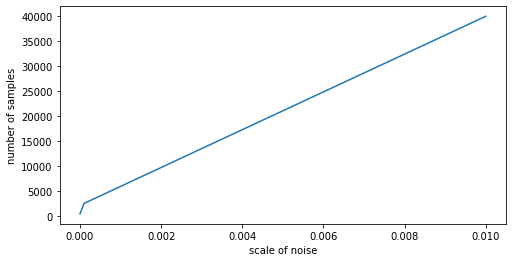

In [ ]:
x = [0,10**-4,10**-3,10**-2]
y = [500,2600,6000,40000]

fig = plt.figure(figsize=(8, 4))
plt.plot(x,y)
plt.xlabel("scale of noise")
plt.ylabel("number of samples")
fig.show() 